<a href="https://colab.research.google.com/github/Gooogr/YOLO_Toolkit/blob/imagenet/Train_yolov4_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil 
import fnmatch

import numpy as np
import cv2
import re

from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
! pip install -q awscli

     |████████████████████████████████| 3.3MB 4.8MB/s 
     |████████████████████████████████| 6.6MB 47.6MB/s 


In [ ]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Tue Sep  8 19:19:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Constants

In [ ]:
CLASS_NAMES = ['Human face', 'Human hand']   # Specify labels from ImageNetv4
SAMPLES_LIMIT = 1000                         # How many image samples of earch class you will use
IS_TINY = True                               # Train YOLOv4 or Tiny YOLOv4 

## Utils

In [ ]:
def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)

## Dataset downloading

In [ ]:
def setup_OIDv4Toolkit():
  ! git clone https://github.com/theAIGuysCode/OIDv4_ToolKit
  % cd OIDv4_ToolKit
  ! pip install -q -r  requirements.txt

In [ ]:
setup_OIDv4Toolkit()

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 40.97 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/OIDv4_ToolKit


In [ ]:
class_names_query = r' '.join(name.replace(' ', '_') for name in CLASS_NAMES)

In [ ]:
# Don't change --multiclasses key value. YOLO requires that all files be in the same folder
! python3 main.py downloader -y \
 --classes {class_names_query}  \
 --type_csv train \
 --limit {SAMPLES_LIMIT} \
 --multiclasses 1


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Human face', 'Human hand'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 61678 KB/s, 0 seconds passed
[DOWNLOAD] | File 

In [ ]:
# Convert annotations to normalazied YOLO version. 
with open('classes.txt', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

! python convert_annotations.py

Currently in subdirectory: train
Converting annotations for class:  Human face_Human hand
100% 197/197 [00:07<00:00, 27.94it/s]


In [ ]:
dataset_folder_name = r'_'.join(name for name in CLASS_NAMES)
dataset_folder_name

'Human face_Human hand'

In [ ]:
# Remove old labels. Count files amount in the dataset (images + labels).
# Name of dataset folder corresponds to the selected labels types: <Class name 1>_<Class name 2>_ ...
! rm -r /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/Label
! ls /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/ | wc -l

394


You have to see value roughly close to (4 * SAMPLES_LIMIT)

In [ ]:
# Move dataset folder to the root of working directory
! mkdir /content/dataset

dest = '/content/dataset'
src = os.path.join('/content/OIDv4_ToolKit/OID/Dataset/train', dataset_folder_name)
src_files = os.listdir(src)

for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, dest)

In [ ]:
# Check that we succesfully move all files
! ls /content/dataset/ | wc -l

394


Data pairs amount: 197


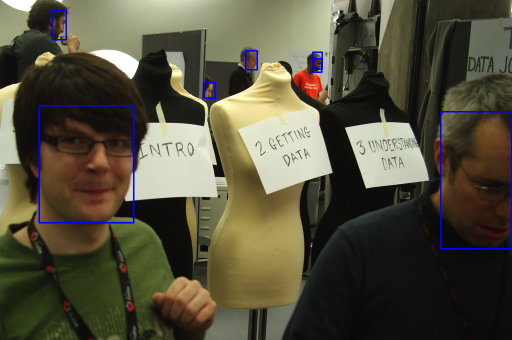

In [ ]:
dir_path = '/content/dataset' 
show_data_sample(dir_path)

## Setting up YOLO Darknet

In [ ]:
% cd /content

/content


In [ ]:
def make_darknet():
  '''
  Make Darknet GPU version 
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [ ]:
%%capture
make_darknet()

In [1]:
def download_pretrained_weights(is_tiny):
    # AlexeAB's cfg files have already been in cfg folder
    if is_tiny:
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
    else:
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
        ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
download_pretrained_weights(IS_TINY)

In [ ]:
def predict_sample(is_tiny):
    % cd /content/darknet
    ! chmod 777 ./darknet
    if is_tiny:
        ! ./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/horses.jpg 
    else:
         ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/horses.jpg 
    image = cv2.imread('predictions.jpg')
    cv2_imshow(image)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max         

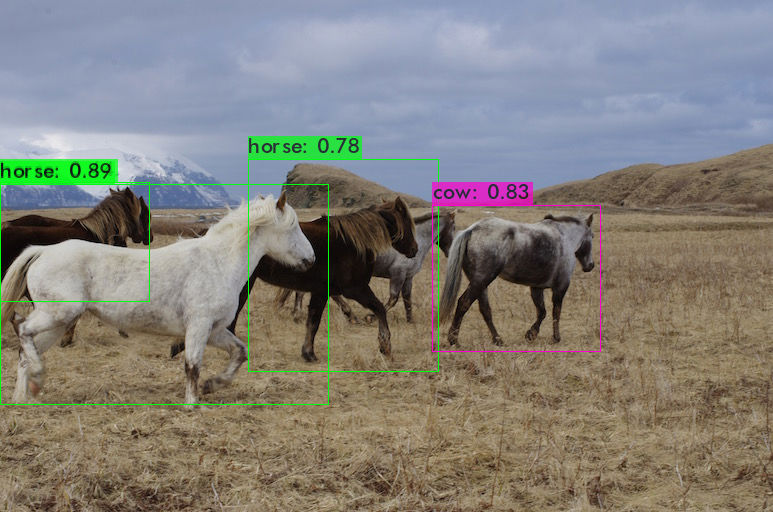

In [ ]:
# check that we get working YOLO version
predict_sample(IS_TINY)

### Prepare config files

In [ ]:
% cd /content/
! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py

/content
--2020-09-08 19:24:02--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657 [text/plain]
Saving to: ‘splitTrainAndTest.py’

splitTrainAndTest.p 100%[===================>]     657  --.-KB/s    in 0s      

2020-09-08 19:24:02 (43.2 MB/s) - ‘splitTrainAndTest.py’ saved [657/657]



In [ ]:
# Create train and test(validate) txt files. Split ratio will be 0.1
! python3 splitTrainAndTest.py /content/dataset

In [ ]:
! mkdir /content/darknet/custom_config_files
% cd /content/darknet/custom_config_files

/content/darknet/custom_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [ ]:
with open('obj.names', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

In [ ]:
! cat obj.names

Human face
Human hand


> yolo.data

Specify classes amount. Check pathes to other files:
```
classses = *amount of your classes*
valid  = /content/test.txt
names = /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train  = /content/train.txt
```
We will create backup folder later

In [ ]:
# Custom magic function for passing python variables into files
# Taken from here: https://github.com/ipython/ipython/issues/6701#issuecomment-382640776
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
labels_amount = len(CLASS_NAMES)

In [ ]:
%%writetemplate yolo.data
classses = {labels_amount}
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

In [ ]:
! cat yolo.data

classses = 2
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

> yolov4.cfg

**Warning! At this step, you will probably need to make some changes to the configuration files manually!**



If you have prepaired .cfg file you can skip this step and download it directly through ```! wget``` command. 
Don't forget, that default names for .cfg file is:
* for tiny yolo - ```yolov4-tiny-custom.cfg```
* for yolo - ```yolov4-custom.cfg```

If you havn`t - follow the code:

In [ ]:
def get_cfg_file(is_tiny):
    if is_tiny:
        ! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-tiny-custom.cfg
    else:
        ! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-custom.cfg

In [ ]:
get_cfg_file(IS_TINY)

--2020-09-08 19:24:03--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/imagenet/cfg_templates/yolov4-tiny-custom.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3027 (3.0K) [text/plain]
Saving to: ‘yolov4-tiny-custom.cfg’

yolov4-tiny-custom. 100%[===================>]   2.96K  --.-KB/s    in 0s      

2020-09-08 19:24:03 (57.6 MB/s) - ‘yolov4-tiny-custom.cfg’ saved [3027/3027]



Generate anchors for cfg file

In [3]:
def generate_anchors(is_tiny, width=None, height=None):
    if  is_tiny and (width is None or height is None):
        width = 416
        height = 416
    elif width is None or height is None:
        width = 608
        height = 608
    % cd /content/darknet
    ! chmod 777 ./darknet
    ! ./darknet detector calc_anchors \
    ./custom_config_files/yolo.data -num_of_clusters {labels_amount} -width {width} -height {height} -show


**Warning!** <br>
**If you are going to set custom** ```width``` **and** ```height``` **in your cfg file, you should specify them in** ```generate_anchors(IS_TINY)``` **as well.**<br>
By default:
* for YOLO v4: ```width```=608 ```height```=608
* for Tiny-YOLO v4: ```width```=416 ```height```=416

In [ ]:
generate_anchors(IS_TINY)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 2, width = 416, height = 416 
classes: Using default '1'
 read labels from 174 images 
 loaded 	 image: 174 	 box: 544
 all loaded. 

 calculating k-means++ ...

 iterations = 10 


counters_per_class = 288, 22327

 avg IoU = 45.31 % 

Saving anchors to the file: anchors.txt 
anchors =  24, 36,  99,126
Unable to init server: Could not connect: Connection refused

(clusters:2816): Gtk-WARNING **: 18:23:25.406: cannot open display: 


### How to configure cfg file

You can find downloaded template of the .cfg file in <br>
```/content/darknet/custom_config_files```<br>
Double click on it and it will open in Google Colab editor window.

Necessary steps:
 * change line batch to ```batch=64```
 * change line subdivisions to ```subdivisions=16```
 * change line max_batches to ```max_batches = number_of_classes * 2000```. For example, for 3 class case max_batches = 6000.
 * change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
 * Set network size
   * for YOLO v4:  ```width=608 height=608``` or any value multiple of 32.
   * for Tiny-YOLO v4:  ```width=416 height=416``` or any value multiple of 32.
 * change line ```classes=number_of_classes``` in each of 3 (in tiny case - 2) ```[yolo]```-layers
 * change ```[filters=255]``` to filters=(classes + 5) * 3 in the 3 (in tiny case - 2) ```[convolutional]``` before each ```[yolo]``` layer. For example, for 3 class model filters = 24
 
* replace ```anchors``` with your custom anchors values.  


Read additional information here: <br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects



In [ ]:
# Create empty directiry for saving weights during the training
! mkdir /content/yolo_weights

### Train YOLOv4

In [ ]:
def train_yolo(is_tiny):
    # Train YOLO
    % cd /content/darknet
    if is_tiny:
        ! ./darknet detector train \
        ./custom_config_files/yolo.data \
        ./custom_config_files/yolov4-tiny-custom.cfg \
        ./yolov4-tiny.conv.29 > /content/temp_train.log -dont_show  
    else:
         ! ./darknet detector train \
        ./custom_config_files/yolo.data \
        ./custom_config_files/yolov4-custom.cfg \
        ./yolov4.conv.137 > /content/temp_train.log -dont_show 

In [ ]:
train_yolo(IS_TINY)